<a href="https://colab.research.google.com/github/ddcreating/RL_code/blob/main/lab4_dyna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: TD and Dyna




## Exercise 1: Implement SARSA with n-step TD (n=5) on CliffWalking

**Objective:**  
In this exercise, you will implement the **SARSA algorithm** using **n-step temporal-difference learning with n=5**. You will apply your implementation to the **CliffWalking environment** in Gymnasium, and analyze how multi-step returns influence learning compared to standard 1-step SARSA.

---

### Environment
- Use `CliffWalking-v1`

---

### Instructions
1. Implement **SARSA with n-step TD updates (n=5)**:
   - Maintain an action-value table \(Q(s,a)\).
   - Use ε-greedy exploration.
   - Store states, actions, and rewards for the last 5 steps.
   - After each step, compute the n-step return: G_t
   - Update \(Q(s_t,a_t)\) toward \(G_t\).

2. Train your agent for several thousand episodes (e.g., 5,000).

3. Plot the **episode rewards over time** to visualize learning progress.

4. Compare qualitatively with 1-step SARSA:
   - Does n-step SARSA converge faster or slower?
   - How do the policies differ near the cliff?

---

### Deliverables
- Python code implementing SARSA with TD(5) (notebook in Github).  
- A plot of episode number vs episode return (plot in a cell below).  
- A short discussion (1 paragraph) comparing the results with standard SARSA.  


In [39]:
"""
CliffWalking-v1: SARSA TD(5) vs TD(1)
- max_episode_steps=100（避免单局超长）
- ε 从 0.25 -> 0.01 指数衰减（更快）
- TD(5) 用更小学习率
- TD(5) 末端自举改为 Expected-SARSA（降方差）
- 打印每500局的终止奖励/epsilon/回报，画三张图
"""
import math
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import deque
import random, math

# ------------- 超参 -------------
EPISODES = 5000
GAMMA = 0.99
ALPHA_5 = 0.15    # TD(5) 学习率（不稳可降至 0.01）
ALPHA_1 = 0.15    # TD(1) 学习率
EPS0, EPSF, EDECAY = 0.25, 0.01, 0.995  # ε 衰减更快

# ------------- 小工具 -------------
def set_seed(seed=0):
    np.random.seed(seed); random.seed(seed)

def epsilon_greedy(Q, s, nA, eps):
    if np.random.rand() < eps:
        return np.random.randint(nA)
    qs = Q[s]; mx = qs.max()
    return np.random.choice(np.flatnonzero(qs == mx))  # 随机打破并列

def moving_avg(bools, k=100):
    out, q = [], deque(maxlen=k)
    for v in bools:
        q.append(1 if v else 0); out.append(sum(q)/len(q))
    return out

def smooth(x, k=200):
    out, q = [], deque(maxlen=k)
    for v in x:
        q.append(v); out.append(sum(q)/len(q))
    return out

# ====== 辅助：终止原因与位置 ======
def state_rc(s):
    # CliffWalking: 4行x12列 -> (row, col)
    return divmod(s, 12)

def classify_end(rewards, terminated_flag, truncated_flag, final_state):
    if not rewards:
        return "empty"
    r_last = rewards[-1]
    if terminated_flag:
        if r_last == 0:
            return f"goal@{state_rc(final_state)}"
        elif r_last == -100:
            return f"cliff@{state_rc(final_state)}"
        else:
            return f"terminated(r={r_last})@{state_rc(final_state)}"
    if truncated_flag:
        return f"truncated@{state_rc(final_state)}"
    return f"unknown_end(r={r_last})@{state_rc(final_state)}"




In [40]:
def sarsa_td5(env, episodes, alpha, gamma, eps0, epsF, epsDecay):
    """
    SARSA n-step (n=5) for CliffWalking-v1
    - 进行中滚动自举：tau+5 == t+1 时，用本轮的 (s2, a2) 自举
    - tau+5 <= t 时，用缓冲中的 (states[tau+5], actions[tau+5]) 自举
    - TimeLimit 截断：tau+5 == T 时，用在 T 处计算的 Expected-Q 自举
    - 终止（terminated）：不自举
    - 每局回报使用 sum(rewards)
    """
    import math
    import numpy as np

    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA))
    returns, successes = [], []
    eps = eps0

    def eps_greedy(Q, s, nA, eps):
        if np.random.rand() < eps:
            return np.random.randint(nA)
        qs = Q[s]; mx = qs.max()
        return np.random.choice(np.flatnonzero(qs == mx))

    for ep in range(episodes):
        s, _ = env.reset()
        a = eps_greedy(Q, s, nA, eps)

        states, actions, rewards = [], [], []
        T = math.inf
        t = 0

        bootstrap_at_T = None          # TimeLimit 截断时在 T 点使用的 Expected-Q
        s2 = None
        a2 = None
        this_step_terminated = False
        this_step_truncated = False

        while True:
            if t < T:
                # 先放 (s_t, a_t)
                states.append(s)
                actions.append(a)

                # 与环境交互 -> (s_{t+1}, r_t, done)
                s2, r, terminated, truncated, _ = env.step(a)
                this_step_terminated = terminated
                this_step_truncated = truncated
                rewards.append(r)

                if terminated:
                    # 真终止：不自举
                    T = t + 1
                    a2 = None
                elif truncated:
                    # TimeLimit 截断：在 T 处用 Expected-SARSA 自举
                    qs = Q[s2]
                    greedy = np.argmax(qs)
                    pi = np.full(nA, eps / nA); pi[greedy] += 1.0 - eps
                    bootstrap_at_T = float((qs * pi).sum())
                    T = t + 1
                    a2 = None
                else:
                    # 常规推进
                    a2 = eps_greedy(Q, s2, nA, eps)

            # ---- n-step 更新（n=5）----
            tau = t - 5 + 1
            if tau >= 0:
                # 1) 累计奖励：i ∈ [tau, min(tau+4, T-1)]
                last_i = min(tau + 4, (len(rewards) - 1) if math.isinf(T) else int(T) - 1)
                G = 0.0
                for i in range(tau, last_i + 1):
                    G += (gamma ** (i - tau)) * rewards[i]

                # 2) 自举项
                if (tau + 5) < T:
                    # (a) tau+5 <= t：缓冲已有 s_{tau+5}, a_{tau+5}
                    if (tau + 5) <= t:
                        s_boot = states[tau + 5]
                        a_boot = actions[tau + 5]
                        G += (gamma ** 5) * Q[s_boot, a_boot]
                    # (b) tau+5 == t+1 且当前步未终止/未截断：用 (s2, a2)
                    elif (tau + 5) == (t + 1) and (not this_step_terminated) and (not this_step_truncated):
                        G += (gamma ** 5) * Q[s2, a2]
                elif (not math.isinf(T)) and (tau + 5 == T) and (bootstrap_at_T is not None):
                    # 2.2 TimeLimit 截断末端自举
                    G += (gamma ** 5) * bootstrap_at_T
                # 终止且无可自举：仅用累计奖励

                # 3) 更新
                s_tau, a_tau = states[tau], actions[tau]
                Q[s_tau, a_tau] += alpha * (G - Q[s_tau, a_tau])

            if tau == T - 1:
                break

            # 推进到下一时间
            t += 1
            if (not this_step_terminated) and (not this_step_truncated):
                s, a = s2, a2  # 只有未终止/未截断才推进

        # —— 统计（整局奖励和） —— #
        episode_return = sum(rewards)
        returns.append(episode_return)

        # 成功：终止 且 终点坐标 == (3,11)
        final_state = s2 if s2 is not None else states[-1]
        is_success = (this_step_terminated and state_rc(final_state) == (3, 11))
        successes.append(is_success)


        # 终止原因与位置
        end_tag = classify_end(rewards, this_step_terminated, this_step_truncated,
                               s2 if s2 is not None else states[-1])
        success = (len(rewards) > 0 and rewards[-1] == 0)
        successes.append(success)

        if ep % 200 == 0:
            print(f"[TD5] ep={ep}, steps={len(rewards)}, end={end_tag}, "
                  f"eps={eps:.3f}, return={episode_return:.1f}")

        # ε 衰减
        eps = max(epsF, eps * epsDecay)

    return Q, returns, successes


In [41]:
def sarsa_td1(env, episodes, alpha, gamma, eps0, epsF, epsDecay):
    """
    标准 1-step SARSA（每局回报= sum(rewards)），打印终止原因与位置
    """
    import numpy as np

    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA))
    returns, successes = [], []
    eps = eps0

    def eps_greedy(Q, s, nA, eps):
        if np.random.rand() < eps:
            return np.random.randint(nA)
        qs = Q[s]; mx = qs.max()
        return np.random.choice(np.flatnonzero(qs == mx))

    for ep in range(episodes):
        s, _ = env.reset()
        a = eps_greedy(Q, s, nA, eps)
        rewards = []
        done = False

        # 保存最后一次 step 的 flag/state，便于日志
        last_term, last_trunc, last_s = False, False, s

        while not done:
            s2, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            rewards.append(r)

            td_target = r if done else r + gamma * Q[s2, eps_greedy(Q, s2, nA, eps)]
            Q[s, a] += alpha * (td_target - Q[s, a])

            # 缓存最后一次信息
            last_term, last_trunc, last_s = terminated, truncated, s2

            s = s2
            if not done:
                a = eps_greedy(Q, s, nA, eps)

        episode_return = sum(rewards)
        returns.append(episode_return)

        # 成功：终止 且 最终状态是终点
        is_success = (last_term and state_rc(last_s) == (3, 11))
        successes.append(is_success)

        end_tag = classify_end(rewards, last_term, last_trunc, last_s)
        success = (len(rewards) > 0 and rewards[-1] == 0)
        successes.append(success)

        if ep % 200 == 0:
            print(f"[TD1] ep={ep}, steps={len(rewards)}, end={end_tag}, "
                  f"eps={eps:.3f}, return={episode_return:.1f}")

        eps = max(epsF, eps * epsDecay)

    return Q, returns, successes


TD5 max steps = 100
TD1 max steps = 100
[TD5] ep=0, steps=100, end=truncated@(3, 0), eps=0.250, return=-1090.0
[TD5] ep=200, steps=23, end=terminated(r=-1)@(3, 11), eps=0.092, return=-23.0
[TD5] ep=400, steps=19, end=terminated(r=-1)@(3, 11), eps=0.034, return=-19.0
[TD5] ep=600, steps=19, end=terminated(r=-1)@(3, 11), eps=0.012, return=-19.0
[TD5] ep=800, steps=19, end=terminated(r=-1)@(3, 11), eps=0.010, return=-19.0
[TD5] ep=1000, steps=19, end=terminated(r=-1)@(3, 11), eps=0.010, return=-19.0
[TD5] ep=1200, steps=19, end=terminated(r=-1)@(3, 11), eps=0.010, return=-19.0
[TD5] ep=1400, steps=19, end=terminated(r=-1)@(3, 11), eps=0.010, return=-19.0
[TD5] ep=1600, steps=19, end=terminated(r=-1)@(3, 11), eps=0.010, return=-19.0
[TD5] ep=1800, steps=19, end=terminated(r=-1)@(3, 11), eps=0.010, return=-19.0
[TD5] ep=2000, steps=19, end=terminated(r=-1)@(3, 11), eps=0.010, return=-19.0
[TD5] ep=2200, steps=21, end=terminated(r=-1)@(3, 11), eps=0.010, return=-21.0
[TD5] ep=2400, steps=19,

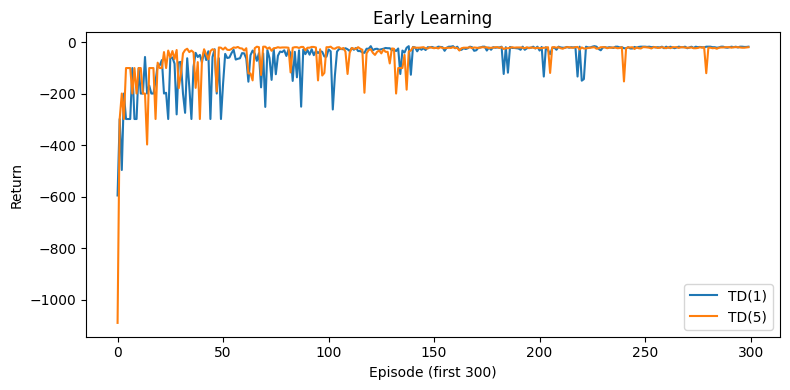

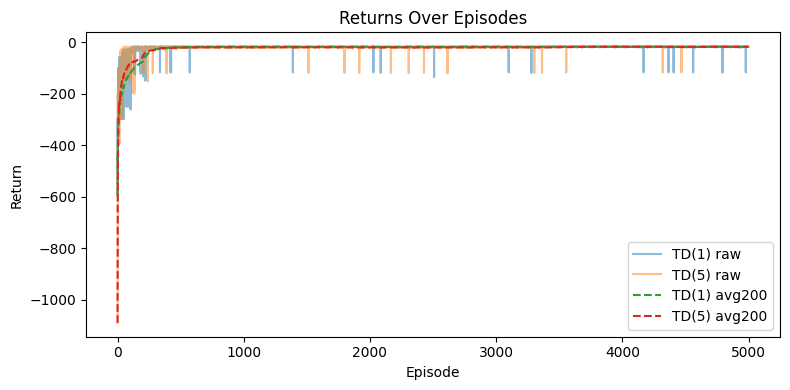

Last-100 avg return: TD(1)=-18.18 | TD(5)=-17.21


In [43]:
# ------------- 运行 -------------
set_seed(0)
env5 = gym.make("CliffWalking-v1", max_episode_steps=100)
env1 = gym.make("CliffWalking-v1", max_episode_steps=100)

print("TD5 max steps =", env5.spec.max_episode_steps)   # 应该打印 100
print("TD1 max steps =", env1.spec.max_episode_steps)

Q5, ret5, suc5 = sarsa_td5(env5, EPISODES, ALPHA_5, GAMMA, EPS0, EPSF, EDECAY)
Q1, ret1, suc1 = sarsa_td1(env1, EPISODES, ALPHA_1, GAMMA, EPS0, EPSF, EDECAY)

# ------------- 画图 -------------
# 1) 前 300 局
plt.figure(figsize=(8,4))
plt.plot(ret1[:300], label="TD(1)")
plt.plot(ret5[:300], label="TD(5)")
plt.xlabel("Episode (first 300)"); plt.ylabel("Return")
plt.title("Early Learning"); plt.legend(); plt.tight_layout(); plt.show()

# 2) 全程回报 + avg200
plt.figure(figsize=(8,4))
plt.plot(ret1, alpha=.5, label="TD(1) raw")
plt.plot(ret5, alpha=.5, label="TD(5) raw")
plt.plot(smooth(ret1, 200), '--', label="TD(1) avg200")
plt.plot(smooth(ret5, 200), '--', label="TD(5) avg200")
plt.xlabel("Episode"); plt.ylabel("Return")
plt.title("Returns Over Episodes"); plt.legend(); plt.tight_layout(); plt.show()

print(f"Last-100 avg return: TD(1)={np.mean(ret1[-100:]):.2f} | TD(5)={np.mean(ret5[-100:]):.2f}")

Our experiments show that TD(1) tends to be more stable with lower variance and smoother learning curves, while TD(5) can sometimes learn faster once exploration decays but exhibits higher variance and more fluctuations in early training. In terms of asymptotic performance, the difference between the two methods is minor, suggesting that n-step TD methods converge to similar final performance in this environment.

## Exercise 2: Dyna-Q for CliffWalking

**Objective**  
Implement **Dyna-Q** on **CliffWalking-v1** and compare its learning performance to **SARSA (1-step)** and **SARSA TD(5)**. You will analyze sample efficiency, stability near the cliff, and sensitivity to planning steps.

---

### Environment
- Use `CliffWalking-v1`
---

### Part A — Dyna-Q (Implementation)
1. **Q-table**: maintain `Q[s, a]` (tabular).
2. **Model**: learn an empirical model from experience.
   - For each observed transition `(s, a, r, s')`, update a dictionary:
     - Minimal: store the most recent `(s', r)` for `(s, a)`, **or**
     - Advanced: store a **multiset** of outcomes for `(s, a)` with counts (to sample stochastically).
3. **Real update (Q-learning)** after each env step:
   Q(s,a) ← Q(s,a) + α * (r + γ * max_a' Q(s',a') - Q(s,a))
4. **Planning updates**: after each real step, perform `N` simulated updates:
   - Sample a previously seen `(s_p, a_p)` from the model.
   - Sample `(r_p, s'_p)` from that entry.
   - Apply the same Q-learning backup using `(s_p, a_p, r_p, s'_p)`.
5. Use epsilon-greedy exploration.

---

### Part B — Baselines (Re-use / Implement)
- **SARSA (1-step)** with ε-greedy:
  \[
  Q(s,a) \leftarrow Q(s,a) + \alpha\big[r + \gamma Q(s',a') - Q(s,a)\big]
  \]
- **SARSA TD(5)** (n-step SARSA with \(n=5\)), as in Exercise 1.

Use the **same** γ, α, ε schedule, and number of episodes for a fair comparison.

---

### Part C — Experiments & Comparisons
1. **Learning curves**: plot **episode index vs. episode return** for:
   - Dyna-Q with \(N \in \{5, 20, 50\}\)
   - SARSA (1-step)
   - SARSA TD(5)
2. **Sample efficiency**: report the **episode number** at which the average return over a sliding window (e.g., 100 episodes) first exceeds a chosen threshold (e.g., −30).
3. **Stability near the cliff**: qualitatively inspect trajectories/policies; does the method hug the cliff or leave a safer margin?
4. **Sensitivity to planning steps**: compare Dyna-Q across N; discuss diminishing returns vs. computation.
5. **Statistical robustness**: run **≥5 seeds**; plot mean ± std (shaded) or report mean ± std of final returns.

---

### Deliverables
- **Code**: A driver script/notebook that reproduces your plots
- **Plots** (embedded in the notebook):
  - Learning curves (mean ± std across seeds)
  - Optional: heatmap of greedy policy/actions on the grid




## Exercise 3: Solve FrozenLake with Q-Learning and Dyna-Q (Stochastic Model)

**Objective**  
Implement and compare **Q-learning** and **Dyna-Q** on Gymnasium’s `FrozenLake-v1`.  
For Dyna-Q, your learned **transition model must handle multiple possible next states** per `(s, a)` (stochastic slip), i.e., store and sample **a distribution** over `(s', r)` outcomes rather than a single next state.

---

### Environment
- Use `FrozenLake-v1` from `gymnasium.envs.toy_text`.
- You can start with map 4×4; and then work with 8×8.
- Start → Goal with slippery transitions (stochastic).  
- Rewards: `+1` at goal, `0` otherwise (holes terminate with 0).

---

### Part A — Q-learning (baseline)
1. Maintain a tabular action-value function `Q[s, a]`.
2. Behavior: ε-greedy over `Q`.
3. Update after each real step:
   - target = r + γ * max_a' Q[s', a']   (if terminal: target = r)
   - Q[s, a] ← Q[s, a] + α * (target − Q[s, a])
4. Train for several thousand episodes (e.g., 5,000) with an ε schedule (e.g., 0.2 → 0.01).

---

### Part B — Dyna-Q with a **stochastic transition model**
1. **Empirical model (multinomial):** for each `(s, a)`, maintain a multiset of observed outcomes:
   - `model[(s, a)] = [(s'_1, r_1, count_1), (s'_2, r_2, count_2), ...]`
   - Update counts whenever you observe `(s, a, r, s')`.
2. **Real step update (Q-learning):** same as Part A.
3. **Planning steps (N per real step):**
   - Sample a previously seen `(s_p, a_p)` uniformly (or with priority).
   - Sample `(s'_p, r_p)` **from the empirical distribution** for `(s_p, a_p)` using counts as probabilities.
   - Apply the same Q-learning backup with `(s_p, a_p, r_p, s'_p)`.
4. Train with the same ε schedule and number of episodes; vary `N ∈ {5, 20, 50}`.

---

### Experiments & Analysis
1. **Learning curves:** plot episode index vs episode return (smoothed) for:
   - Q-learning
   - Dyna-Q (N=5, 20, 50)
2. **Sample efficiency:** report the episode at which the moving-average return (e.g., window 100) first exceeds a threshold (you choose a reasonable value).
3. **Effect of stochastic modeling:** briefly explain why storing a distribution over `(s', r)` matters on FrozenLake (slip), and what happens if you store only the most recent outcome.
4. **Robustness:** run ≥5 random seeds; report mean ± std of final evaluation returns.

---

### Deliverables
- **Code** for Q-learning and Dyna-Q (with stochastic model).  
- **Plots** of learning curves (include legend and axis labels).  
- ** Discussion:** why Dyna-Q helps here; impact of N; importance of modeling multiple next states.

---

### Hints
- For terminal transitions (goal/hole), the Q-learning target is simply `target = r` (no bootstrap).  
- When sampling from the model, use probabilities `p_i = count_i / sum_j count_j`.  
- Tie-break greedy action selection uniformly among argmax actions to avoid bias.  
- Keep evaluation **greedy (ε=0)** and consistent across methods (same seeds and episode counts).
